In [1]:
%matplotlib inline

import pymongo
import seaborn as sns

In [2]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """

    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [3]:
client = pymongo.MongoClient()
db = client.metrics

cb_td, cb_vd, sc_td, sc_vd = "CB_TAGGING_TD_FEAT_SELECTION", "CB_TAGGING_VD_FEAT_SELECTION", "SC_TAGGING_TD_FEAT_SELECTION", "SC_TAGGING_VD_FEAT_SELECTION"
cb_td, cb_vd, sc_td, sc_vd = db[cb_td], db[cb_vd], db[sc_td], db[sc_vd]
cb_td, cb_vd, sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_VD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_VD_FEAT_SELECTION'))

# Query Top Features

In [4]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            "window_size":    "$parameters.window_size",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

In [5]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

#cb_vd_df.head(10)

In [6]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2017-01-30T21:19:41.374000000'),
 numpy.datetime64('2017-02-01T07:07:40.430000000'))

In [7]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision,window_size".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df, win_size = 9):
    df_top_individual_feats = df[(df["count"] == 1) & (df["window_size"] == win_size)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

#get_top_individual_feats(cb_vd_df, 11)

### Performance of Each Feature In Isolation for Best Window Size (9)

In [10]:
import numpy as np
a, b = get_top_individual_feats(cb_vd_df, 9), get_top_individual_feats(sc_vd_df, 9)
merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC".split(",")]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC
0,1,pos_wd_feats_stemmed[offset:4],0.812696,0.746745,0.891425,pos_wd_feats_stemmed[offset:4],0.791081,0.739942,0.849815
1,2,pos_wd_feats[offset:4],0.805718,0.733816,0.893240,pos_wd_feats[offset:4],0.788498,0.732895,0.853231
2,3,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.769784,0.666406,0.911124,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.761874,0.678736,0.868223
3,4,pos_ngram_feat[ngram_size:2offset:4],0.753309,0.643435,0.908435,pos_ngram_feat[ngram_size:2offset:4],0.754270,0.666823,0.868114
4,5,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.701923,0.565291,0.925656,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.697205,0.577128,0.880375
5,6,pos_ngram_feat[ngram_size:3offset:4],0.677654,0.534682,0.924993,pos_ngram_feat[ngram_size:3offset:4],0.684264,0.560183,0.878955
6,7,bow_ngram_feat[ngram_size:2offset:4],0.610527,0.494723,0.797113,bow_ngram_feat[ngram_size:2offset:4],0.601519,0.493138,0.770958
7,8,bow_ngram_feat[ngram_size:1offset:4],0.597930,0.514898,0.712888,bow_ngram_feat[ngram_size:3offset:4],0.576502,0.442334,0.827495
8,9,bow_ngram_feat[ngram_size:3offset:4],0.574350,0.432364,0.855189,extract_dependency_relation,0.572233,0.467266,0.738022
9,10,extract_dependency_relation,0.557585,0.412971,0.858062,bow_ngram_feat[ngram_size:1offset:4],0.567397,0.472904,0.709082


## Generate Rows for LaTex Table

In [25]:
def format_lbl(lbl):
    return lbl.replace("["," ").replace("]","").replace("_"," ").strip()

## Perfomance By Window Size

In [11]:
def get_by_window_size(df):
    return group_by(df, bycols=["window_size"], agg_map=[("micro_f1_score", "max"),
                                              #("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("window_size")

by_win_size = pd.merge(get_by_window_size(cb_vd_df), get_by_window_size(sc_vd_df), on="window_size", suffixes=["_CB", "_SC"])
by_win_size

,window_size,max(micro_f1_score)_CB,max(micro_f1_score)_SC
0,1,0.705959,0.705046
1,3,0.772429,0.759586
2,5,0.810162,0.786957
3,7,0.822694,0.799258
4,9,0.824667,0.801090
5,11,0.824443,0.800888
6,13,0.822428,0.799787


### <span style="color:red">NOTE that for BOTH, optimal window size is now 9</span>

## Plot TD vs VD F1 Score For CB By Window Size

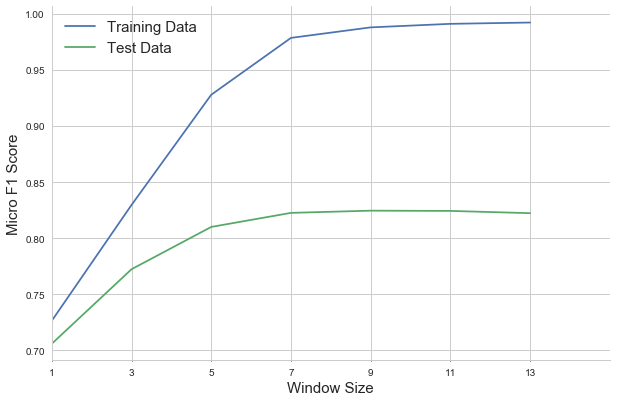

In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = pd.merge(
    get_by_window_size(cb_td_df), 
    get_by_window_size(cb_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+2, 2.0), fontsize=10)
plt.yticks(fontsize=10)

sns.despine()
plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/cb_f1_vs_win_size.png")
plt.show()

## Plot TD vs VD F1 Score For SC By Window Size

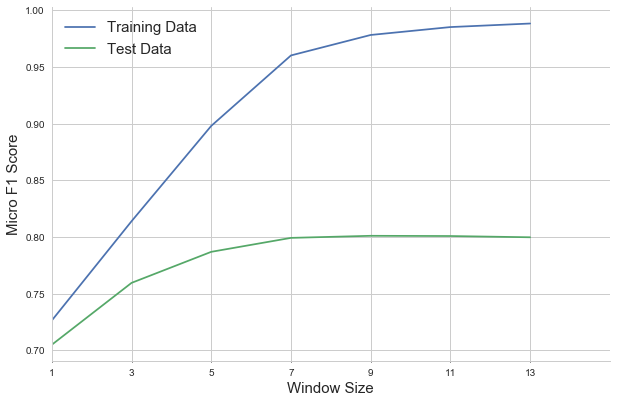

In [13]:
FONT_SIZE = 15

df = pd.merge(
    get_by_window_size(sc_td_df), 
    get_by_window_size(sc_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+2, 2.0), fontsize=10)
plt.yticks(fontsize=10)

sns.despine()
plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/sc_f1_vs_win_size.png")
plt.show()

## Performance By Feature Set Size

In [14]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,mean(micro_f1_score)_cb,max(micro_f1_score)_sc,mean(micro_f1_score)_sc
0,1,0.813492,0.549772,0.792558,0.554299
1,2,0.819141,0.785654,0.799118,0.768705
2,3,0.822749,0.797302,0.800872,0.779004
3,4,0.823567,0.802461,0.801090,0.782500
4,5,0.824233,0.805277,0.800949,0.785157
5,6,0.824667,0.806893,0.800888,0.781282


### <span style="color:red">NOTE: Optimal SC performance Tails off After 4 features</span>

# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [15]:
#cols_filter = "count,new_feat,micro_f1_score,micro_recall,micro_precision,window_size".split(",")
cols_filter = "count,new_feat,micro_f1_score,window_size".split(",")

def get_f1_by_feat_count(df):
    #max_feats = df["count"].values.max()
    
    top_feats = df[df["window_size"] == 9]
    top_feats = top_feats[top_feats["count"] == 6]
    top_feats = top_feats.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]
    
    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", how="outer", suffixes=("_CB", "_SC"))
df_f1_score_by_feat_size
# Note that the optimal feature set for SC is only of size 4

,count,new_feat_CB,micro_f1_score_CB,window_size_CB,new_feat_SC,micro_f1_score_SC,window_size_SC
0,1,pos_wd_feats_stemmed[offset:4],0.812696,9,pos_wd_feats_stemmed[offset:4],0.791081,9
1,2,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.819141,9,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.799118,9
2,3,bow_ngram_feat[ngram_size:1offset:4],0.822749,9,extract_brown_cluster,0.800872,9
3,4,extract_brown_cluster,0.823567,9,bow_ngram_feat[ngram_size:1offset:4],0.801090,9
4,5,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.824233,9,extract_dependency_relation,0.800949,9
5,6,extract_dependency_relation,0.824667,9,pos_wd_feats[offset:4],0.800255,9


In [16]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))  
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
df

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,pos_wd_feats_stemmed[offset:4],0.8127,pos_wd_feats_stemmed[offset:4],0.7911
1,2,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.8191,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.7991
2,3,bow_ngram_feat[ngram_size:1offset:4],0.8227,extract_brown_cluster,0.8009
3,4,extract_brown_cluster,0.8236,bow_ngram_feat[ngram_size:1offset:4],0.8011
4,5,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.8242,extract_dependency_relation,0.8009
5,6,extract_dependency_relation,0.8247,pos_wd_feats[offset:4],0.8003


# Plot F1 Score Against # Feature Sets

### Get the Max F1 Score for Each Size of Feature Set (Win = 9)

In [17]:
def get_max_f1_by_feat_count(df):
    max_feats = df["count"].values.max()
    rows = []
    for cnt in range(1, max_feats+1):
        
        row = df[df["count"] == cnt].sort_values("micro_f1_score", ascending=False).iloc[0]        
        rows.append(row)

    return pd.DataFrame(rows)

In [18]:
sc_vd_df[sc_vd_df["window_size"] == 9]["count"].unique()

array([4, 5, 3, 6, 2, 1])

In [19]:
df_cb = get_max_f1_by_feat_count(cb_vd_df[cb_vd_df["window_size"] == 9])[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall", "window_size"]]
df_sc = get_max_f1_by_feat_count(sc_vd_df[sc_vd_df["window_size"] == 9])[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall", "window_size"]]
by_feat_size = pd.merge(df_cb, df_sc, on="count", how="outer", suffixes=["_CB", "_SC"])
by_feat_size

,count,feats_CB,micro_f1_score_CB,micro_precision_CB,micro_recall_CB,window_size_CB,feats_SC,micro_f1_score_SC,micro_precision_SC,micro_recall_SC,window_size_SC
0,1,[fn_pos_wd_feats_stemmed[offset:4]],0.812696,0.891425,0.746745,9,[fn_pos_wd_feats_stemmed[offset:4]],0.791081,0.849815,0.739942,9
1,2,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.819141,0.898793,0.752458,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.799118,0.857918,0.747861,9
2,3,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.822749,0.885141,0.768574,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.800872,0.856990,0.751653,9
3,4,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.823567,0.884369,0.770588,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.801090,0.847829,0.759236,9
4,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.824233,0.885508,0.770889,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.800949,0.848267,0.758632,9
5,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.824667,0.886629,0.770799,9,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.800255,0.845958,0.759236,9


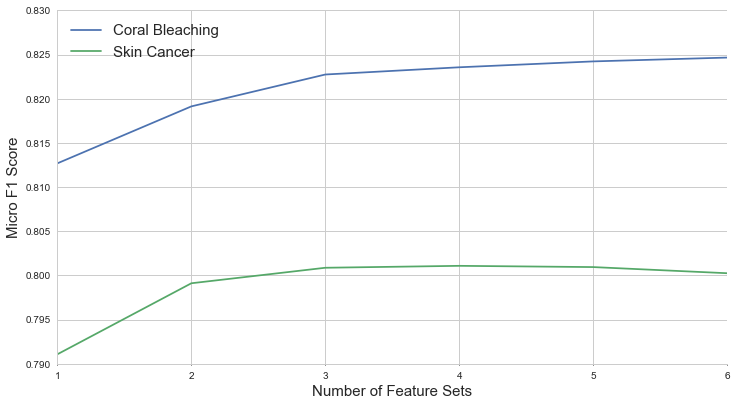

In [20]:
FONT_SIZE = 15

df = by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 6])
ax1.set_ylim([0.79, 0.83])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

### F1 Score As Individual Features are Added

In [26]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(str(row["new_feat_SC"]))
    if feats_SC == "nan":
        feats_SC = "-"
        
    micro_f1_score_SC = row["micro_f1_score_SC"]
    if str(micro_f1_score_SC) != "nan":
        micro_f1_score_SC = "{0:0.4f}".format(micro_f1_score_SC)
    else:
        micro_f1_score_SC = "-"
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.4f} & & {feat_sc} & {sc_f1}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

1 & pos wd feats stemmed offset:4 & 0.8127 & & pos wd feats stemmed offset:4 & 0.7911\\
2 & pos ngram feat stemmed ngram size:2offset:4 & 0.8191 & & pos ngram feat stemmed ngram size:2offset:4 & 0.7991\\
3 & bow ngram feat ngram size:1offset:4 & 0.8227 & & extract brown cluster & 0.8009\\
4 & extract brown cluster & 0.8236 & & bow ngram feat ngram size:1offset:4 & 0.8011\\
5 & pos ngram feat stemmed ngram size:3offset:4 & 0.8242 & & extract dependency relation & 0.8009\\
6 & extract dependency relation & 0.8247 & & pos wd feats offset:4 & 0.8003\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [22]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"

In [23]:
a = df_sc[df_sc["count"] >=4]["feats"].values
a[0]

[u'fn_pos_wd_feats_stemmed[offset:4]',
 u'fn_pos_ngram_feat_stemmed[ngram_size:2 offset:4]',
 u'extract_brown_cluster',
 u'fn_bow_ngram_feat[ngram_size:1 offset:4]']

In [24]:
a[1]

[u'fn_pos_wd_feats_stemmed[offset:4]',
 u'fn_pos_ngram_feat_stemmed[ngram_size:2 offset:4]',
 u'extract_brown_cluster',
 u'fn_bow_ngram_feat[ngram_size:1 offset:4]',
 u'extract_dependency_relation']